In [1]:
import pandas as pd
import numpy as np
from salty import check_name
import salty
import keras
import pickle
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn import metrics
%matplotlib inline

Using TensorFlow backend.


In [2]:
pickle_in = open("salts+descriptors.pkl", "rb")
df = pickle.load(pickle_in)
target=df['Specific density, kg/m<SUP>3</SUP>']
print('The target shape:'+ str(target.shape))
df=df.drop(['name-cation','name-anion','smiles-anion','smiles-cation','salt_name','Specific density, kg/m<SUP>3</SUP>'],axis=1)
print('The feature shape:'+ str(df.shape))
column_names=df.columns
df.to_csv('salts+descriptors.csv')

The target shape:(25991,)
The feature shape:(25991, 190)


In [3]:
min_max=MinMaxScaler() #tranforming features
features=min_max.fit_transform(df) 

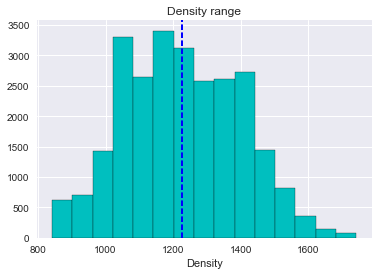

In [4]:
plt.hist(target,bins=15,color='c',edgecolor='black')
plt.axvline(target.mean(), color='b', linestyle='dashed', linewidth=2)
plt.xlabel('Density')
plt.title('Density range')

In [5]:
#calculating features with lasso
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
parameters = {"alpha": list(np.linspace(1,10,10))}
model = Lasso(alpha=0.2)
model.fit(X_train,y_train)
model.coef_
y_pred=model.predict(X_test)
lasso_r2=metrics.r2_score(y_test,y_pred)
print('The R2 for lasso: '+ str(metrics.r2_score(y_test,y_pred)))
print('The RMSE for lasso: '+ str(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('The R2 for cross_val_score training data: '+str(np.mean(cross_val_score(model,X_train,y_train,cv=5))))
print('The R2 for cross_val_score test data: '+str(np.mean(cross_val_score(model,X_test,y_test,cv=5))))

The R2 for lasso: 0.945708966562
The RMSE for lasso: 39.7799032968
The R2 for cross_val_score training data: 0.947949671732
The R2 for cross_val_score test data: 0.946643311219


parameters = {"alpha": list(np.linspace(0.1,10,20))}
model = Lasso()
grid = GridSearchCV(model,parameters)
grid_result = grid.fit(features,target)
print(grid_result.best_estimator_)

lasso=grid_result.best_estimator_
lasso_crossval=cross_val_score(lasso,features,target,cv=10) #returns R^2 predictions
print(lasso_crossval)
avg_lasso=np.mean(lasso_crossval)
avg_lasso

In [6]:
X_train, X_Test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
rf=RandomForestRegressor(n_jobs=-1,n_estimators=10) #returns r^2 predictions #
rf.fit(X_train,y_train)
y_pred=rf.predict(X_Test)
rf_r2=metrics.r2_score(y_test,y_pred)
print('The R2 for RandomForest: '+ str(metrics.r2_score(y_test,y_pred)))
print('The RMSE for RandomForest: '+ str(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
feature_importance=rf.feature_importances_
scores=pd.DataFrame({'feature':column_names,'score':feature_importance}).sort_values(by='score',ascending=False)
scores_top90=scores[:90]

The R2 for RandomForest: 0.998409056027
The RMSE for RandomForest: 6.80968638945


In [7]:
top=[]
for i in scores_top90['feature']:
    top.append(i)
features_svr=df[top]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
svr=SVR(kernel='linear') #returns r^2 predictions
svr.fit(X_train,y_train)
y_pred=svr.predict(X_test)
svr_r2=metrics.r2_score(y_test,y_pred)
print(metrics.r2_score(y_test,y_pred))
np.sqrt(metrics.mean_squared_error(y_test,y_pred))

0.927179431866


46.070900410499178

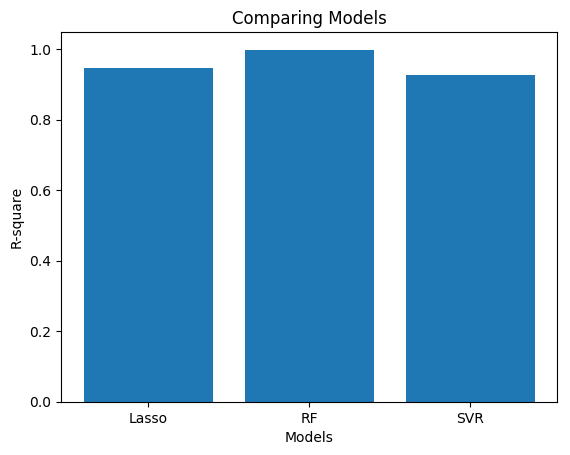

In [9]:
plt.rcdefaults()
objects = ('Lasso', 'RF','SVR')
y_pos = np.arange(len(objects))
metric=[lasso_r2,rf_r2,svr_r2]
plt.bar(y_pos, metric, align='center', alpha=1)
plt.xticks(y_pos,objects)
plt.xlabel('Models')
plt.ylabel('R-square')
plt.title('Comparing Models')
plt.show()

Questions:
* Any suggestions for hyperparameter tuning/feature selection ?
* svr took too long, anyone used it?

Future work:  
* scale the features, with the minimum or the mean?
* explore various feature selection options and different metrics
* expand the data-base to get more unique smiles for CNN